In [3]:
# STEP 1: Install and Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm

In [2]:
# STEP 2: Load and preprocess MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# STEP 3: Define Beta schedule (linear schedule)
T = 300
beta = np.linspace(1e-4, 0.02, T, dtype=np.float32)
alpha = 1.0 - beta
alpha_hat = np.cumprod(alpha)


In [4]:
# STEP 4: Forward Diffusion Process

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = tf.random.normal(shape=x_start.shape)
    sqrt_alpha_hat_t = tf.gather(tf.sqrt(alpha_hat), t)
    sqrt_one_minus_alpha_hat_t = tf.gather(tf.sqrt(1 - alpha_hat), t)
    sqrt_alpha_hat_t = tf.reshape(sqrt_alpha_hat_t, (-1, 1, 1, 1))
    sqrt_one_minus_alpha_hat_t = tf.reshape(sqrt_one_minus_alpha_hat_t, (-1, 1, 1, 1))
    return sqrt_alpha_hat_t * x_start + sqrt_one_minus_alpha_hat_t * noise


In [5]:
# STEP 5: Build a simple U-Net-like model

def get_model():
    inputs = layers.Input(shape=(28, 28, 1))
    t_input = layers.Input(shape=(1,))  # timestep input

    # Embed time step (simple embedding)
    t_emb = layers.Embedding(T, 32)(t_input)
    t_emb = layers.Dense(28*28)(t_emb)
    t_emb = layers.Reshape((28,28,1))(t_emb)

    x = layers.Concatenate()([inputs, t_emb])

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, 3, padding='same')(x)

    return tf.keras.Model([inputs, t_input], outputs)

model = get_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │      9,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 784)    │     25,872 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28, 2) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        608 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     18,464 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28, 1) │        289 │ conv2d_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,257 (430.69 KB)

 Trainable params: 110,257 (430.69 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# STEP 6: Optimizer & Loss function

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError()


In [7]:
# STEP 7: Training Step

@tf.function
def train_step(x):
    batch_size = tf.shape(x)[0]
    t = tf.random.uniform(minval=0, maxval=T, shape=(batch_size,), dtype=tf.int32)
    noise = tf.random.normal(shape=tf.shape(x))
    x_t = q_sample(x, t, noise)

    with tf.GradientTape() as tape:
        pred_noise = model([x_t, t])
        loss = mse(noise, pred_noise)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss


In [11]:
# STEP 8: Full Training Loop

EPOCHS = 20

for epoch in range(EPOCHS):
    pbar = tqdm(train_dataset)
    for batch in pbar:
        loss = train_step(batch)
        pbar.set_description(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss:.4f}")


Epoch [20/20] Loss: 0.0478: 100%|██████████| 469/469 [00:08<00:00, 52.61it/s]


In [9]:
# STEP 9: Sampling (reverse diffusion)

def sample(model, n_samples=16):
    imgs = tf.random.normal((n_samples, 28, 28, 1))

    for t_ in reversed(range(T)):
        t_tensor = tf.constant([t_] * n_samples, dtype=tf.int32)
        pred_noise = model([imgs, t_tensor])
        alpha_t = alpha[t_]
        alpha_hat_t = alpha_hat[t_]
        beta_t = beta[t_]

        coef1 = 1 / np.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / np.sqrt(1 - alpha_hat_t)

        if t_ > 0:
            noise = tf.random.normal(shape=imgs.shape)
        else:
            noise = tf.zeros_like(imgs)

        imgs = coef1 * (imgs - coef2 * pred_noise) + np.sqrt(beta_t) * noise

    imgs = (imgs + 1.0) / 2.0
    return imgs

generated_imgs = sample(model)


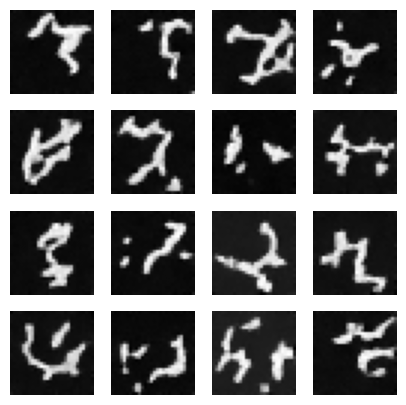

In [12]:
# STEP 10: Plot Generated Images

plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_imgs[i,:,:,0], cmap='gray')
    plt.axis('off')
plt.show()


Version 2

In [4]:
import tensorflow as tf #to build and train neural networks.
import numpy as np #for array operations.
import matplotlib.pyplot as plt #to visualize images and noise
from tensorflow.keras import layers
from tqdm import tqdm #to create progress bars.
import random #for selecting samples for visualization

In [5]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()  #Load MNIST digits.
x_train = (x_train.astype(np.float32) / 255.0) * 2.0 - 1.0  # Normalize pixel values from [0,255] to [-1,1] — diffusion models work better in symmetric scale.
x_train = np.expand_dims(x_train, axis=-1) #Add channel dimension (28x28x1) to match CNN input.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(BATCH_SIZE) #Create shuffled dataset for efficient training.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


STEP 4: Forward Diffusion — Add noise to clean image

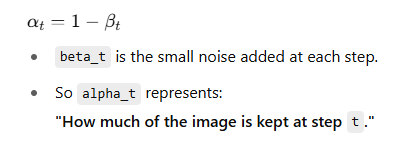

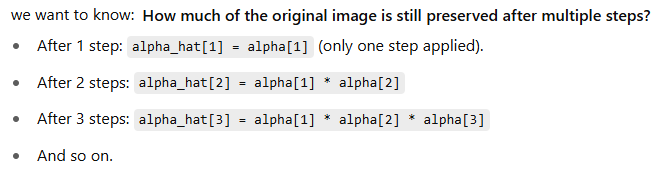

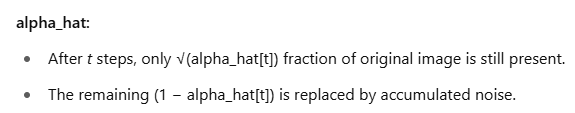

In [6]:
T = 300  # Total diffusion steps #We will add noise to images in T=300 small steps.
beta = np.linspace(1e-4, 0.02, T, dtype=np.float32) #beta controls how much noise is added at each step.
alpha = 1.0 - beta #beta controls how much noise is added at each step.
alpha_hat = np.cumprod(alpha) #Multiply together all the alpha values from timestep 1 to timestep t.
                              #alpha_hat helps track how much "clean image" remains after each step
                              #This slow, gradual noising allows neural networks to later learn how to reverse it.


This function simulates the forward diffusion process.

In [7]:
# It adds small amounts of noise depending on timestep t.
# Over 300 steps, clean image turns into pure random noise.
# This is how we create noisy training data for the model to learn from.
def q_sample(x_start, t, noise=None):  #This function takes a clean image and simulates how noisy it would be after t steps of adding noise.
     #x_start: The clean original image (before adding any noise).
     # t: The current diffusion timestep (from 0 to T-1).
     # noise: Optional — if not provided, random noise will be generated inside.
    if noise is None:
        noise = tf.random.normal(shape=x_start.shape) #  If you didn’t pass any noise, it automatically generates random Gaussian noise of same shape as the image.
        #Every time we train, we want different random noise added, so the model sees many noisy versions.
    sqrt_alpha_hat_t = tf.gather(tf.sqrt(alpha_hat), t)
    sqrt_one_minus_alpha_hat_t = tf.gather(tf.sqrt(1 - alpha_hat), t)
    sqrt_alpha_hat_t = tf.reshape(sqrt_alpha_hat_t, (-1, 1, 1, 1))
    sqrt_one_minus_alpha_hat_t = tf.reshape(sqrt_one_minus_alpha_hat_t, (-1, 1, 1, 1))
    return sqrt_alpha_hat_t * x_start + sqrt_one_minus_alpha_hat_t * noise

STEP 5: Build the model (Simple U-Net)

In [8]:
def get_model():
    inputs = layers.Input(shape=(28, 28, 1)) # Input shape = 28x28 grayscale image (single channel).
                                             # This is the noisy image that the model will receive as input at each diffusion step.
    t_input = layers.Input(shape=(1,))    # Timestep Input Layer: Each sample also receives its corresponding timestep t as input.
                                          # Because the amount of noise depends on which step you're at.
    t_emb = layers.Embedding(T, 32)(t_input)  # Embedding layer for timestep:
                                              #T is the total number of timesteps.
                                              #Each timestep gets mapped into a 32-dimensional vector.
                                              #This allows the model to "understand" which timestep it's operating on,
                                              # by turning scalar t into a richer vector representation.
    t_emb = layers.Dense(28*28)(t_emb)
    # Project timestep embedding to image size:
    # We transform the 32-dim vector into a vector of size 28x28 = 784.
    # This reshaping helps to broadcast the timestep info across the full spatial size of the image.
    t_emb = layers.Reshape((28,28,1))(t_emb)
    #Reshape timestep vector into image shape:
    #Reshape the flat vector into an image-shaped tensor: (28, 28, 1).
    #Now both image and timestep embeddings are aligned in spatial dimensions.

    x = layers.Concatenate()([inputs, t_emb])
    #Concatenate image and timestep info:
    #Combine both the noisy image and timestep embedding along the channel axis.
    #Output shape: (28, 28, 2).
    #Now every pixel has both image value + timestep info.

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    #First convolution layer:
    # 32 filters of size 3x3.
    #ReLU activation introduces non-linearity. padding='same' ensures output stays 28x28.
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    # Second convolution:
    # Increases filter count to 64 for more feature capacity.
    # More expressive power to capture complex patterns.
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    #Third convolution: Additional depth to extract richer hierarchical features.
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    # Fourth convolution: Start reducing the channel count back down, moving toward the output.
    #This keeps the model size reasonable and avoids overfitting.
    outputs = layers.Conv2D(1, 3, padding='same')(x)
    # Final output layer: 1 filter to map back to a single-channel image (same as input).
    #No activation: model outputs raw noise prediction.
    return tf.keras.Model([inputs, t_input], outputs)

model = get_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │      9,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 784)    │     25,872 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28, 2) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        608 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     18,464 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28, 1) │        289 │ conv2d_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,257 (430.69 KB)

 Trainable params: 110,257 (430.69 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError() # Use Mean Squared Error: because we're predicting noise values directly.

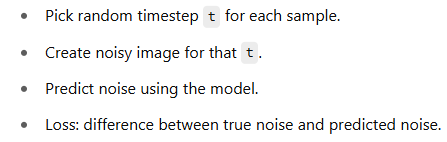

In [10]:
@tf.function
def train_step(x):
    batch_size = tf.shape(x)[0]
    t = tf.random.uniform(minval=0, maxval=T, shape=(batch_size,), dtype=tf.int32)
    noise = tf.random.normal(shape=tf.shape(x))
    x_t = q_sample(x, t, noise)

    with tf.GradientTape() as tape:
        pred_noise = model([x_t, t])
        loss = mse(noise, pred_noise)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss


In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):  #After training: model can predict noise for any level of noising.
    pbar = tqdm(train_dataset)
    for batch in pbar:
        loss = train_step(batch)
        pbar.set_description(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss:.4f}")


Epoch [10/10] Loss: 0.0523: 100%|██████████| 469/469 [00:10<00:00, 45.87it/s]


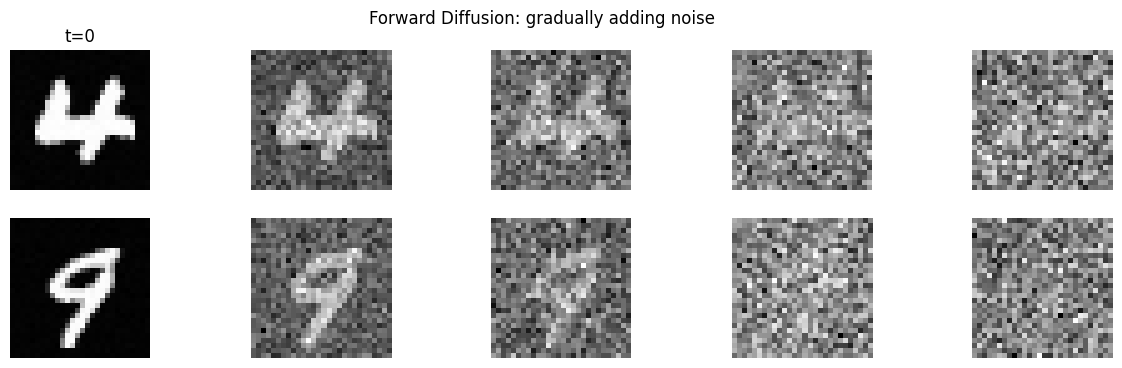

In [12]:
sample_indices = random.sample(range(len(x_train)), 2)
x_samples = tf.convert_to_tensor(x_train[sample_indices], dtype=tf.float32)

plt.figure(figsize=(15, 4))

for i, t_val in enumerate([0, T//4, T//2, (3*T)//4, T-1]):
    t = tf.constant([t_val]*2)
    x_noisy = q_sample(x_samples, t)
    x_noisy = (x_noisy + 1) / 2

    for j in range(2):
        plt.subplot(2, 5, j*5 + i+1)
        plt.imshow(x_noisy[j, :, :, 0], cmap='gray')
        plt.axis('off')
        if j == 0 and i == 0:
            plt.title(f"t={t_val}")

plt.suptitle("Forward Diffusion: gradually adding noise")
plt.show()


In [13]:
# STEP 10: Sampling (reverse denoising)

def sample(model, n_samples=2):
    imgs = tf.random.normal((n_samples, 28, 28, 1))

    # Store intermediate steps for visualization
    images_over_time = []

    for t_ in reversed(range(T)):
        t_tensor = tf.constant([t_] * n_samples, dtype=tf.int32)
        pred_noise = model([imgs, t_tensor])
        alpha_t = alpha[t_]
        alpha_hat_t = alpha_hat[t_]
        beta_t = beta[t_]

        coef1 = 1 / np.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / np.sqrt(1 - alpha_hat_t)

        if t_ > 0:
            noise = tf.random.normal(shape=imgs.shape)
        else:
            noise = tf.zeros_like(imgs)

        imgs = coef1 * (imgs - coef2 * pred_noise) + np.sqrt(beta_t) * noise

        if t_ in [T-1, int(T*0.75), int(T*0.5), int(T*0.25), 0]:  # store few steps
            images_over_time.append((imgs + 1) / 2)

    return images_over_time

# Generate samples for 2 digits
generated_imgs = sample(model)


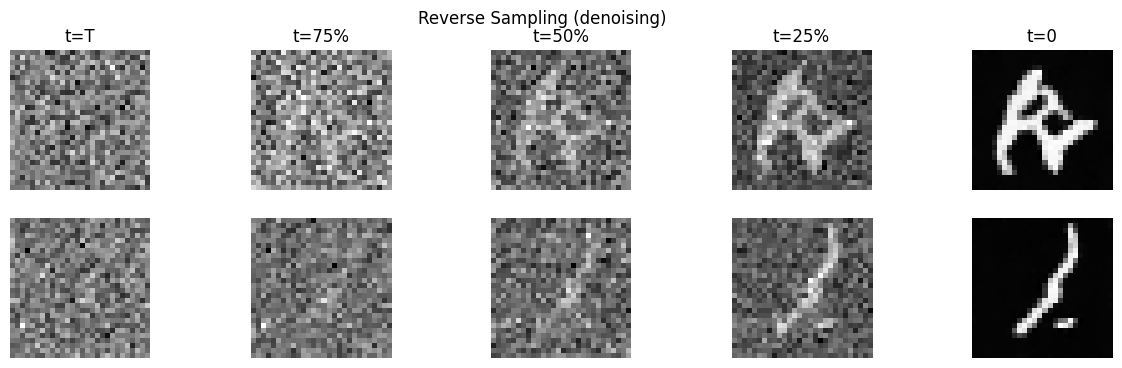

In [14]:
# STEP 11: Visualizing Reverse Sampling Process

plt.figure(figsize=(15, 4))
for i, imgs in enumerate(generated_imgs):
    for j in range(2):
        plt.subplot(2, 5, j*5 + i+1)
        plt.imshow(imgs[j, :, :, 0], cmap='gray')
        plt.axis('off')
        if j == 0:
            titles = ["t=T", "t=75%", "t=50%", "t=25%", "t=0"]
            plt.title(titles[i])

plt.suptitle("Reverse Sampling (denoising)")
plt.show()
